## Final Model Evaluation

We compare four pipelines:

1. Classical
2. Torch
3. Hybrid
4. Combined (PCA+Landmarks)

Metrics: accuracy & macro-F1 on **dev** (in-distribution) and **test** (out-of-distribution), plus confusion matrices.

In [2]:
from CombinedPipeline import CombinedPipeline
from HybridPipeline import HybridPipeline
from TorchPipeline import TorchPipeline
from ClassicalPipeline import ClassicalPipeline
from utils import get_image_paths_and_labels
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

TRAIN_DIR = 'data/asl_alphabet_train'
DEV_DIR = 'data/asl_alphabet_dev'
TEST_DIR = 'data/synthetic_test'

seed = 42
random.seed(seed)
np.random.seed(seed)

train_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR)
dev_paths, dev_labels = get_image_paths_and_labels(DEV_DIR)
test_paths, test_labels = get_image_paths_and_labels(TEST_DIR)

classes = sorted(os.listdir(TRAIN_DIR))
subset_to_plot = [clazz for clazz in classes if clazz not in ['del', 'space']]

MODEL_DIR = 'models'
paths = {
    'Classical': os.path.join(MODEL_DIR, 'classical_pipeline.pkl'),
    'Torch': os.path.join(MODEL_DIR, 'torch_pipeline.pth'),
    'Hybrid': os.path.join(MODEL_DIR, 'hybrid_pipeline.pkl'),
    'Combined': os.path.join(MODEL_DIR, 'combined_pipeline.pkl'),
}

# load
pipes = {
    'Classical': ClassicalPipeline().load(paths['Classical']),
    'Torch': TorchPipeline(device).load(paths['Torch']),
    'Hybrid': HybridPipeline().load(paths['Hybrid']),
    'Combined': CombinedPipeline().load(paths['Combined']),
}


Using device: mps


I0000 00:00:1746982553.270260 13508086 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
I0000 00:00:1746982553.282488 13508086 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1746982553.284809 13508086 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
I0000 00:00:1746982553.352521 13508086 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro


In [4]:
# evaluate on dev & test
records = []
for name, pipe in pipes.items():
    for split, paths, labels, in [('dev', dev_paths, dev_labels), ('test', test_paths, test_labels)]:
        ans = pipe.evaluate(paths, labels)
        acc, f1, cm = ans['accuracy'], ans['f1_macro'], ans['cm']
        records.append({
            'model': name,
            'split': split,
            'accuracy': acc,
            'f1_macro': f1,
            'cm': cm
        })

df = pd.DataFrame(records)


Extracting hand landmarks:   0%|          | 0/11600 [00:00<?, ?it/s]/Users/oliver/Development/PythonProjects/Math-DS/.venv2/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Extracting hand landmarks:   0%|          | 0/2700 [00:00<?, ?it/s]/Users/oliver/Development/PythonProjects/Math-DS/.venv2/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Extracting hand landmarks:   0%|          | 0/11600 [00:00<?, ?it/s]/Users/oliver/Development/PythonProjects/Math-DS/.venv2/lib/python3.11/site-pac

In [26]:
def metrics_from_cm(cm: np.ndarray) -> dict:
    tp = np.diag(cm).astype(float)
    fp = cm.sum(axis=0).astype(float) - tp
    fn = cm.sum(axis=1).astype(float) - tp

    # avoid division by zero
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) > 0)
    recall = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) > 0)

    # per-class F1
    denom = precision + recall
    f1 = np.divide(2 * precision * recall, denom, out=np.zeros_like(tp), where=denom > 0)

    return {
        'Accuracy': tp.sum() / cm.sum(),
        'Precision': precision.mean(),
        'Recall': recall.mean(),
        'F1': f1.mean(),
    }


# Apply to each row of df
records = []
for _, row in df.iterrows():
    m = metrics_from_cm(row['cm'])
    m.update({'model': row['model'], 'split': row['split']})
    records.append(m)

df_metrics = pd.DataFrame(records)

# Pivot into a clean table
metrics_table = df_metrics.pivot(index='model', columns='split')[
    ['Accuracy', 'Precision', 'Recall', 'F1']
]
metrics_table

Accuracy           Precision              Recall            \
split           dev      test       dev      test       dev      test   
model                                                                   
Classical  0.988707  0.044074  0.988802  0.034842  0.988707  0.041034   
Combined   0.977759  0.357037  0.978134  0.429455  0.977759  0.332414   
Hybrid     0.796379  0.378148  0.926354  0.460386  0.796379  0.352069   
Torch      0.998017  0.285185  0.998025  0.335948  0.998017  0.265517   

                 F1            
split           dev      test  
model                          
Classical  0.988704  0.024918  
Combined   0.977845  0.342509  
Hybrid     0.842523  0.360553  
Torch      0.998017  0.268247

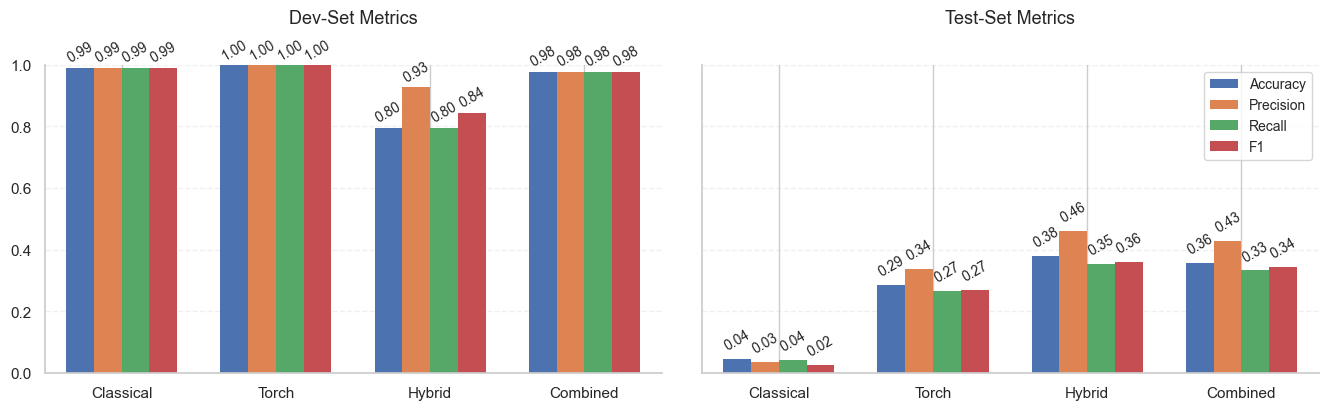

In [33]:
models = list(pipes.keys())
metric_titles = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(models))
width = 0.18

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Super-title already handled earlier; now just subplots
for ax, split in zip(axes, ['dev', 'test']):
    for i, metric in enumerate(metric_titles):
        vals = metrics_table[metric][split].loc[models].values
        bars = ax.bar(
            x + (i - 1.5) * width,
            vals,
            width,
            label=metric,
            edgecolor='none'
        )
        for bar in bars:
            h = bar.get_height()
            offset = 0.01 if split == 'dev' else 0.02
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                h + offset,
                f"{h:.2f}",
                ha='center',
                va='bottom',
                fontsize=10,
                rotation=30
            )

    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=11)
    ax.set_title(f"{split.capitalize()}-Set Metrics", fontsize=13, pad=30)
    ax.set_ylim(0, 1.0)
    ax.set_xlim(-0.5, len(models) - 0.5)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Legend only once
axes[1].legend(loc='upper right', fontsize=10)

fig.subplots_adjust(left=0.07, right=0.98, top=0.88, wspace=0.065)
plt.show()

**Figure**: Comparison of four pipelines on dev‐ and test‐sets across four metrics (accuracy, precision, recall, F₁).

- **Dev-set**: All models score near 100%; except for Hybrid. **Torch** scores the highest.
- **Test-set**:
  - **Classical** collapses (F₁ ≈ 0.02).
  - **Torch** yields moderate generalization (F₁ ≈ 0.27).
  - **Hybrid** and **Combined** improves further (F₁ ≈ 0.36 and F₁ ≈ 0.34 respectively).

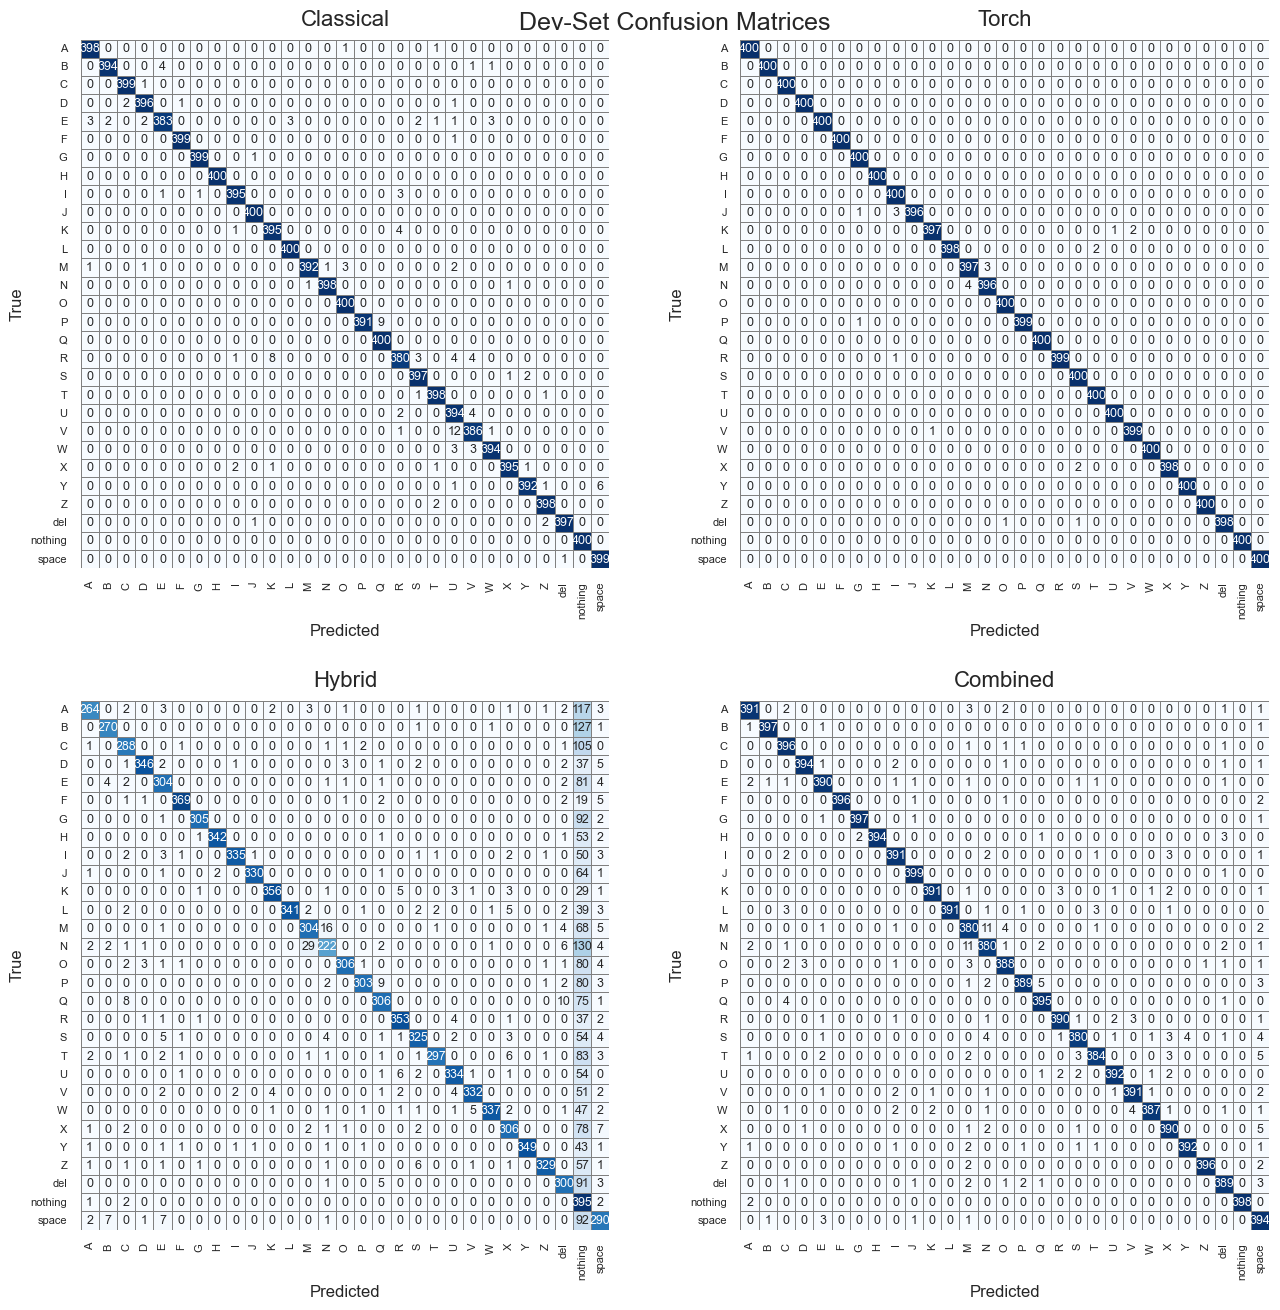

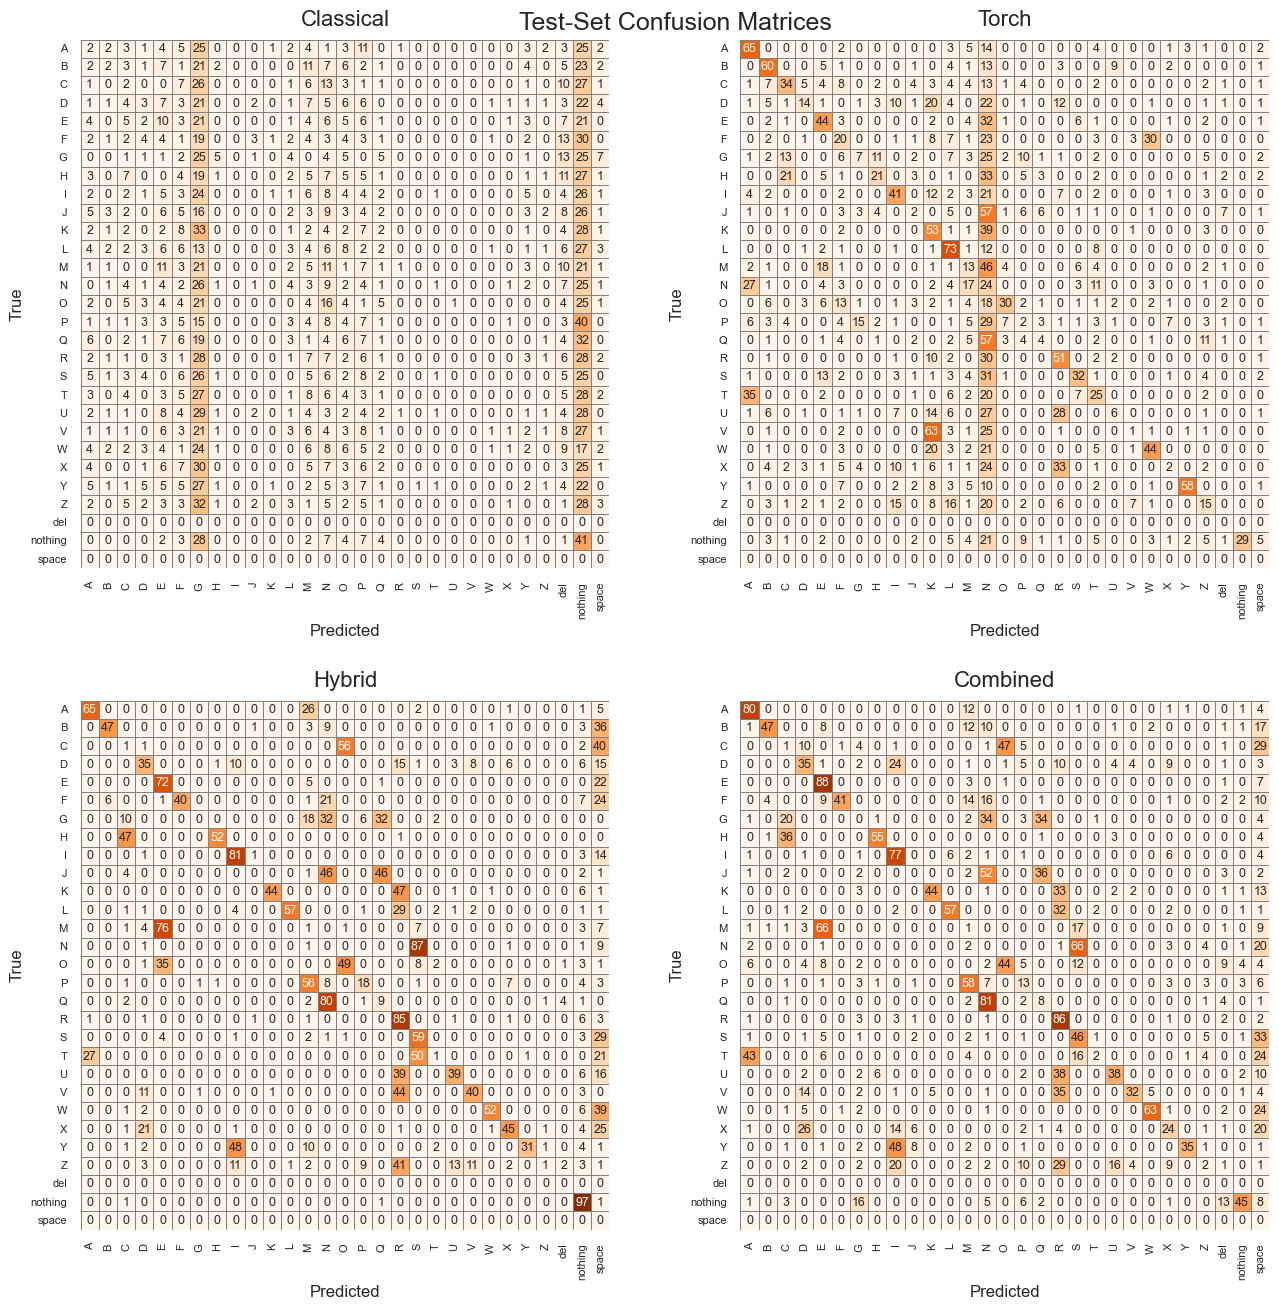

In [53]:
models = ['Classical', 'Torch', 'Hybrid', 'Combined']
class_names = sorted(
    d for d in os.listdir(DEV_DIR)
    if os.path.isdir(os.path.join(DEV_DIR, d))
)


def plot_cm_grid(split: str, cmap: str = 'Blues'):
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    fig.suptitle(f"{split.capitalize()}-Set Confusion Matrices", fontsize=18, y=0.92)

    for idx, model in enumerate(models):
        row, col = divmod(idx, 2)
        cm = df.loc[(df.model == model) & (df.split == split), 'cm'].iloc[0]

        row_sums = cm.sum(axis=1, keepdims=True)
        cmn = np.divide(
            cm.astype(float),
            row_sums,
            out=np.zeros_like(cm, dtype=float),
            where=row_sums > 0
        )

        ax = axes[row, col]
        sns.heatmap(
            cmn,
            annot=cm,
            fmt='d',
            cmap=cmap,
            vmin=0, vmax=1,
            square=True,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 9},
            ax=ax,
        )
        ax.set_title(model, fontsize=16, pad=10)
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('True', fontsize=12)
        ax.tick_params(axis='x', rotation=90, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.subplots_adjust(
        left=0.05, right=0.95,
        top=0.90, bottom=0.05,
        hspace=0.25,
        wspace=0.1
    )
    plt.show()


plot_cm_grid('dev', cmap='Blues')
plot_cm_grid('test', cmap='Oranges')

Dev-set (top) vs. Test-set (bottom) confusion matrices for each pipeline:

- **Classical**
  - Dev: nearly diagonal (almost no errors).
  - Test: heavy off-diagonal a lot of pictures are misclassified in many ways. It usually predicts 'G' or 'nothing'

- **Torch**
  - Dev: closest to perfect diagonal.
  - Test: fewer errors than Classical.

- **Hybrid**
  - Dev: a few small errors (usually they are false 'nothing'-s).
  - Test: one of the best, meaning it generalizes somewhat to new backgrounds and hands

- **Combined**
  - Dev: almost perfect.
  - Test: one of the best, meaning it generalizes somewhat to new backgrounds and hands
  - I think this is the best model overall on both training and dev sets


Top-3 Confusion Pairs (True → Predicted : Count):
  Q → N : 81
  M → E : 66
  N → S : 66


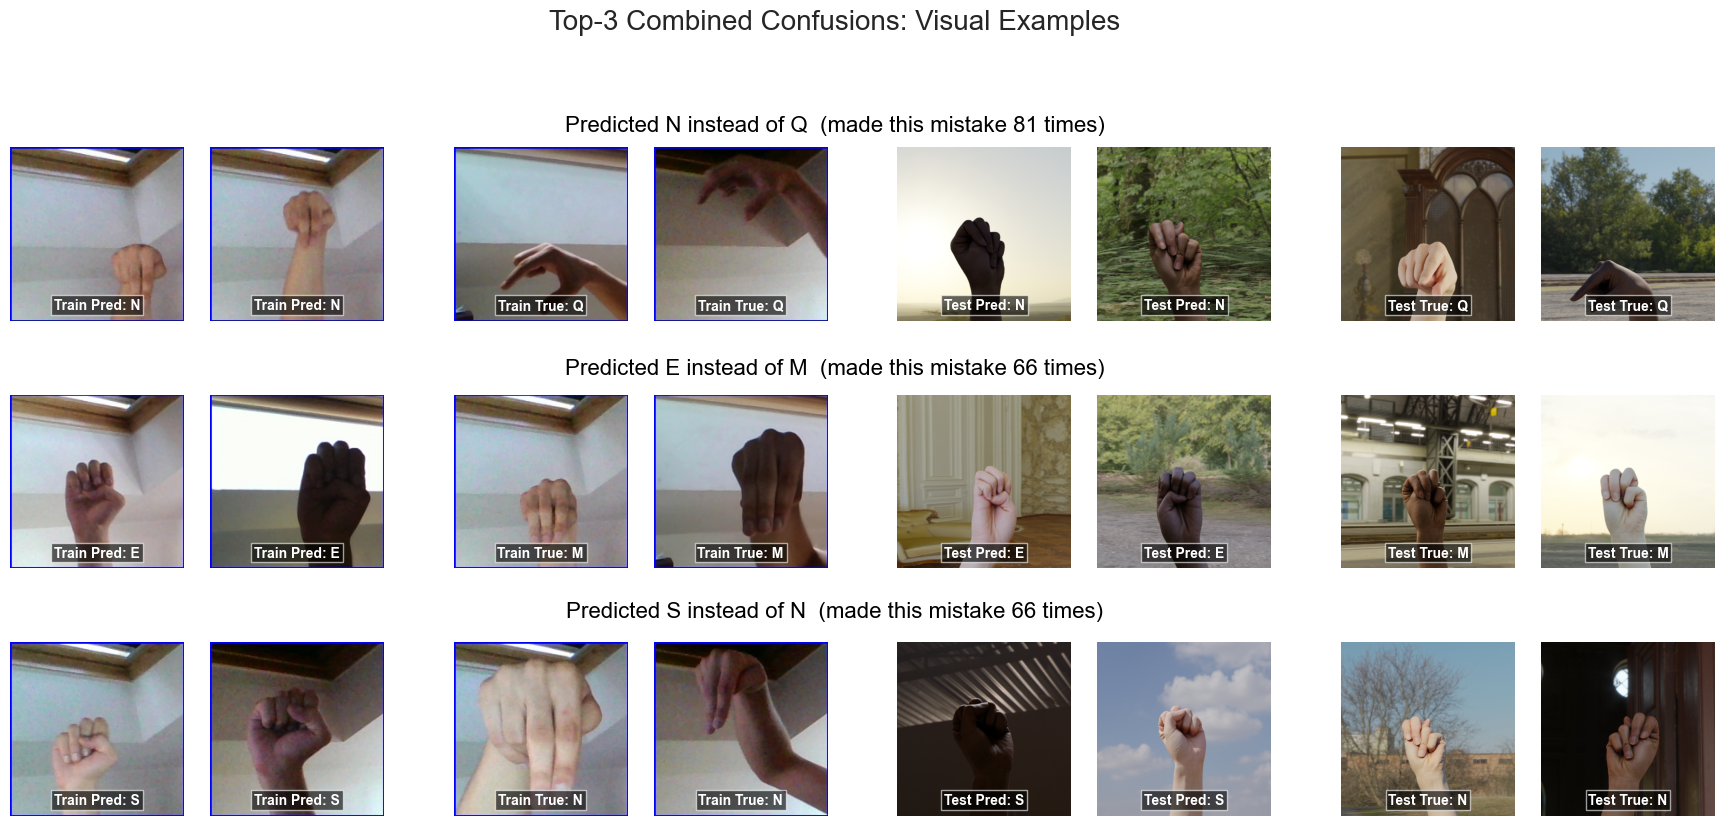

In [76]:
# Cell X — Top-3 Confusions with Tighter Layout & Split-Aware Labels

# 1) Load the Combined/test confusion matrix & find top-3 pairs
cm = df.loc[(df.model == 'Combined') & (df.split == 'test'), 'cm'].iloc[0]
class_names = sorted(
    d for d in os.listdir(DEV_DIR)
    if os.path.isdir(os.path.join(DEV_DIR, d))
)
n = len(class_names)
pairs = [((i, j), cm[i, j]) for i in range(n) for j in range(n) if i != j]
pairs.sort(key=lambda x: x[1], reverse=True)
top3 = pairs[:3]

print("Top-3 Confusion Pairs (True → Predicted : Count):")
for (t, p), cnt in top3:
    print(f"  {class_names[t]} → {class_names[p]} : {cnt}")

# 2) Get train/test file paths & labels
train_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR)
test_paths, test_labels = get_image_paths_and_labels(TEST_DIR)

# 3) Set up a 3×11 grid so each group of 2 images is tight, with tiny gaps
fig = plt.figure(figsize=(22, 9))
gs = fig.add_gridspec(
    nrows=3, ncols=11,
    width_ratios=[1, 1, 0.1, 1, 1, 0.1, 1, 1, 0.1, 1, 1],
    hspace=0.25
)
axes = [[fig.add_subplot(gs[r, c]) for c in range(11)] for r in range(3)]

# 4) Main title
fig.suptitle("Top-3 Combined Confusions: Visual Examples", fontsize=20, y=1.02)

# 5) For each confusing pair, draw the row title and 2×4 images
for row, ((true_i, pred_i), cnt) in enumerate(top3):
    true_cls, pred_cls = class_names[true_i], class_names[pred_i]

    # Row title (plain text, no box), just above its row
    fig.text(
        0.5,
        0.88 - row * 0.27,  # shift down each row
        f"Predicted {pred_cls} instead of {true_cls}  (made this mistake {cnt} times)",
        ha='center', va='bottom',
        fontsize=16, color='black'
    )

    # Sample 2 examples each
    tp = [p for p, l in zip(train_paths, train_labels) if l == pred_i]
    tt = [p for p, l in zip(train_paths, train_labels) if l == true_i]
    ep = [p for p, l in zip(test_paths, test_labels) if l == pred_i]
    et = [p for p, l in zip(test_paths, test_labels) if l == true_i]
    samp = {
        'train_pred': random.sample(tp, 2),
        'train_true': random.sample(tt, 2),
        'test_pred': random.sample(ep, 2),
        'test_true': random.sample(et, 2),
    }

    # Map groups → columns
    col_map = {
        'train_pred': [0, 1],
        'train_true': [3, 4],
        'test_pred': [6, 7],
        'test_true': [9, 10],
    }

    # Plot each image & overlay "Split Type: Class"
    for key, cols in col_map.items():
        split = 'Train' if key.startswith('train') else 'Test'
        typ = 'Pred' if 'pred' in key else 'True'
        for idx_img, col in enumerate(cols):
            ax = axes[row][col]
            img = Image.open(samp[key][idx_img])
            ax.imshow(img)
            ax.axis('off')
            ax.text(
                0.5, 0.05,
                f"{split} {typ}: {true_cls if typ == 'True' else pred_cls}",
                transform=ax.transAxes,
                ha='center', va='bottom',
                color='white', fontsize=10, fontweight='bold',
                bbox=dict(facecolor='black', alpha=0.6, pad=2)
            )

    # Blank out spacer columns
    for sp in (2, 5, 8):
        axes[row][sp].axis('off')

plt.show()

**Figure**: Visual examples of the top-3 confusions made by the **Combined** pipeline.
Each row shows one confusion pair: 4 train examples on the left and 4 test examples on the right.

1. **Q → N**: Both test Q and train N are two fingers pointing downwards, and test N looks nothing like that
2. **M → E**: Test M clearly looks more like train E than train M.
3. **N → S**: Test N looks different from all the others

These side-by-side comparisons illustrate that the most common mistakes are not because the model is bad, but because some categories look different in the training and dev sets.
